In [1]:
from utils import preprocess_text, labelnum

import os
from glob import glob
from pathlib import Path
from datetime import timedelta, datetime, timezone

import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

import pandas as pd
import pyarrow.parquet as pq

In [2]:
MODEL_PATH = Path('./models/sentiment/')

model = BertForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
device = "cuda" if torch.cuda.is_available() else "cpu"

get_sentiment = pipeline('sentiment-analysis',
                         model=model,
                         tokenizer=tokenizer,
                         max_length=512,
                         batch_size=128,
                         truncation=True,
                         device=device
                         )

label_map = {'LABEL_0': 'negative',
             'LABEL_1': 'neutral',
             'LABEL_2': 'positive'}

# Issue comments (Only Jira)


In [2]:
issues = pq.ParquetFile('./data/20-MAD/issues.parquet').read().to_pandas()

issues.columns

Index(['source', 'product', 'issue_id', 'issue_key', 'created', 'updated',
       'last_resolved', 'summary', 'description', 'version', 'milestone',
       'status', 'severity', 'priority', 'issuetype', 'resolution',
       'component', 'votes', 'product_name', 'reporter_key', 'reporter_tz',
       'creator_key', 'creator_tz', 'assignee_key', 'assignee_tz'],
      dtype='object')

In [3]:
columns_to_drop = ['summary', 'description']
issues.drop(columns=columns_to_drop, inplace=True)

In [4]:
issues = issues[issues['source'] == 'apache']

len(issues)

883065

In [5]:
non_nullable_issue_columns = ["product", "issue_id", "priority", "issuetype"]
issues = issues.dropna(subset=non_nullable_issue_columns)

len(issues)

870471

In [6]:
issues['priority'].value_counts()


priority
Major       582743
Minor       177287
Critical     39798
Blocker      28303
Trivial      26907
Normal        8359
Low           6473
Urgent         590
High            11
Name: count, dtype: int64

In [7]:
expected_issue_priorities = ['Blocker', 'Critical', 'Major', 'Minor', 'Trivial']
issues = issues[issues['priority'].isin(expected_issue_priorities)]

len(issues)

855038

In [11]:
# save modified issues
issues.to_parquet('./data/processed/20-MAD/rq/issues_for_rq_3_4.parquet', index=False)

# merge issue comments

In [8]:
issue_comment_metadata = pq.ParquetFile('./data/processed/20-MAD/rq/issues_for_rq_3_4.parquet').read().to_pandas()

In [14]:
from glob import glob

nlcomment_files = glob('./data/20-MAD//nlp/jira/apache/*/*_nlcomments.parquet')
nlcomment_files.sort()

len(nlcomment_files)

653

In [15]:
sample = pq.ParquetFile(nlcomment_files[0]).read().to_pandas()
sample.head()

,source,product,issue_id,comment_id,paragraph_id,text,nchar
0,apache,AAR,12963270,15261151,1,"Watch The Ultimate Fighter Season 23, Episode ...",61
1,apache,AAR,12963270,15261151,2,"Watch The Ultimate Fighter Season 23, Episode ...",61
2,apache,AAR,12963270,15261151,3,"Watch The Ultimate Fighter Season 23, Episode ...",61
3,apache,AAR,12963270,15261151,4,"Watch The Ultimate Fighter Season 23, Episode ...",61
4,apache,AAR,12963270,15261151,5,"Watch The Ultimate Fighter Season 23, Episode ...",61


In [16]:
schema = pq.ParquetFile(nlcomment_files[0]).schema_arrow
with pq.ParquetWriter("./data/processed/20-MAD/rq/issue_comments_without_metadata.parquet", schema=schema) as writer:
    for file in nlcomment_files:
        writer.write_table(pq.read_table(file, schema=schema))

In [17]:
issue_comments_without_metadata = pq.ParquetFile(
    './data/processed/20-MAD/rq/issue_comments_without_metadata.parquet').read().to_pandas()

In [19]:
issue_comments_without_metadata.columns

Index(['source', 'product', 'issue_id', 'comment_id', 'paragraph_id', 'text',
       'nchar'],
      dtype='object')

In [20]:
text_column = 'text'
non_nullable_columns = [text_column, 'product', 'issue_id', 'comment_id', 'paragraph_id']
issue_comments_without_metadata.dropna(subset=non_nullable_columns, inplace=True)

len(issue_comments_without_metadata)

16861861

In [22]:
issue_comments_without_metadata["source"].value_counts()

source
apache    16861861
Name: count, dtype: int64

In [23]:
issue_comments_without_metadata_text_merged = \
    issue_comments_without_metadata.groupby(['product', 'issue_id', 'comment_id'], as_index=False)['text'].apply(
        ' '.join).reset_index()


AttributeError: 'DataFrame' object has no attribute 'write_parquet'

In [24]:
issue_comments_without_metadata_text_merged.to_parquet(
    './data/processed/20-MAD/rq/issue_comments_without_metadata_text_merged.parquet', index=False)

In [25]:
len(issue_comments_without_metadata_text_merged)

3957479

In [27]:
# merge with issue metadata
issue_comments_merged = issue_comments_without_metadata_text_merged.merge(issue_comment_metadata,
                                                                          on=['product', 'issue_id'], how='inner')
issue_comments_merged.to_parquet('./data/processed/20-MAD/rq/issue_comments_merged.parquet', index=False)

In [28]:
len(issue_comments_merged)

3814162

In [34]:
issue_comments_merged["priority"].value_counts()

priority
Major       2608952
Minor        688099
Critical     239380
Blocker      185884
Trivial       91847
Name: count, dtype: int64

In [31]:
issue_comments_merged["issuetype"].value_counts()

issuetype
Bug                                      1876548
Improvement                               938443
Sub-task                                  386933
New Feature                               319914
Task                                      183403
Test                                       37420
Wish                                       25608
Question                                    7333
Documentation                               5858
Dependency upgrade                          5745
Story                                       5082
Umbrella                                    4698
Technical task                              2755
Project                                     2462
Planned Work                                2455
Epic                                        2326
Brainstorming                               1645
Github Integration                           982
SVN->GIT Migration                           817
New Git Repo                                 775
New JIRA P

In [33]:
issue_comments_merged.columns

Index(['index', 'product', 'issue_id', 'comment_id', 'text', 'source',
       'issue_key', 'created', 'updated', 'last_resolved', 'version',
       'milestone', 'status', 'severity', 'priority', 'issuetype',
       'resolution', 'component', 'votes', 'product_name', 'reporter_key',
       'reporter_tz', 'creator_key', 'creator_tz', 'assignee_key',
       'assignee_tz'],
      dtype='object')

In [ ]:
# we need [product,issue_id,comment_id,priority,issue_type,text_sentiment]

In [38]:
text_column = 'text'
columns_of_interest = [text_column, 'product', 'issue_id', 'comment_id', 'source', 'priority', 'issuetype']

issue_comments_merged = issue_comments_merged[columns_of_interest]
issue_comments_merged[text_column] = issue_comments_merged[text_column].apply(preprocess_text)
issue_comments_merged.to_parquet('./data/processed/20-MAD/rq/issue_comments.parquet', index=False)

# Sentiment Classification

In [3]:
text_column = 'text'
common_columns = ['product', 'issue_id', 'comment_id', 'priority', 'issuetype']
inout_columns_of_interest = [text_column] + common_columns
output_columns_of_interest = [f'{text_column}_sentiment'] + common_columns

In [4]:
DATA_PATH = Path('./data/processed/20-MAD/rq/issue_comments.parquet')
OUTPUT_PATH = Path('./data/processed/20-MAD/rq/issue_comments_with_sentiment.csv')
PREVIOUSLY_PROCESSED_PATHS = [OUTPUT_PATH,
                              Path('./data/processed/20-MAD/temp/issue_comments_with_sentiment_temp_01.csv'),
                              Path('./data/processed/20-MAD/temp/issue_comments_with_sentiment_temp_02.csv'),
                              Path('./data/processed/20-MAD/temp/issue_comments_with_sentiment_temp_03.csv'),
                              Path('./data/processed/20-MAD/temp/issue_comments_with_sentiment_temp_04.csv'),
                              ]

In [5]:
previously_processed = pd.DataFrame()
for path_ in PREVIOUSLY_PROCESSED_PATHS:
    if path_.exists():
        previous_output = pd.read_csv(path_)
        previously_processed = pd.concat([previously_processed, previous_output], ignore_index=True)
previously_processed.drop_duplicates(inplace=True)

len(previously_processed)

3814162

In [6]:
data = pq.ParquetFile(DATA_PATH).read().to_pandas()
data.drop_duplicates(inplace=True)

# because we want data that has not been processed
data_columns = data.columns
temp = data.merge(previously_processed, on=common_columns, how='left', indicator=True)
data = temp[temp['_merge'] == 'left_only'][data_columns]

len(data)

0

In [14]:
previously_processed.sample(5)

,text_sentiment,product,issue_id,comment_id,priority,issuetype
33138,positive,AIRAVATA,13246354.0,16962081.0,Major,Sub-task
3454595,neutral,SOLR,12374601.0,12562871.0,Minor,Improvement
3462869,neutral,SMX4,12490072.0,12961161.0,Major,Task
2246347,negative,LUCENE,12511180.0,13053115.0,Major,Improvement
2260709,neutral,LUCENE,12634938.0,13637780.0,Major,Bug


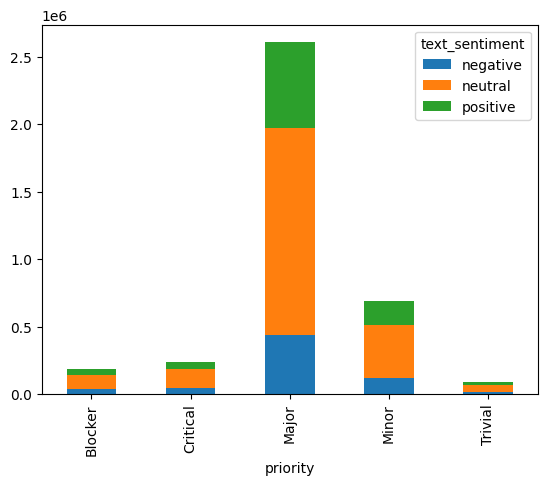

In [13]:
# plot bar chart of neutral, positive, negative based on priority
import matplotlib.pyplot as plt

sentiment_priority = previously_processed.groupby(['priority', 'text_sentiment']).size().unstack()
sentiment_priority.plot(kind='bar', stacked=True)
plt.show()


In [19]:
if len(data) == 0:
    # save rq_3_4 as no entries are remaining to process
    previously_processed['issuetype'] = previously_processed['issuetype'].apply(lambda x: 'bug' if x == 'Bug' else 'non-bug')
    previously_processed.to_csv('./data/processed/20-MAD/rq/rq_3_4.csv', index=False)
    

In [20]:
# get number of duplicates in previously_processed
previously_processed.duplicated().sum()

0

In [7]:
    # if OUTPUT_PATH.exists():
#     -------------OUTPUT_PATH.unlink()
#     print(f"removed {OUTPUT_PATH}")

In [8]:
count = 0
chunk_size = 8192

chunks = [data[i:i + chunk_size] for i in range(0, data.shape[0], chunk_size)]

In [9]:
from pandas.errors import SettingWithCopyWarning
import warnings

warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

In [ ]:
for i, chunk in enumerate(chunks):
    sentiments = get_sentiment(chunk[text_column].tolist())
    sentiment_labels = [label_map[sentiment['label']] for sentiment in sentiments]
    chunk[f'{text_column}_sentiment'] = sentiment_labels
    # chunk.drop(columns=[text_column], inplace=True)

    if OUTPUT_PATH.exists():
        chunk.to_csv(OUTPUT_PATH, mode='a', columns=output_columns_of_interest, index=False, header=False)
    else:
        chunk.to_csv(OUTPUT_PATH, mode='w', columns=output_columns_of_interest, index=False, header=True)

    count += chunk.shape[0]
    print(f"{datetime.now().isoformat(sep=' ', timespec='seconds')}: processed {count} issue comments")

2024-06-08 02:31:44: processed 8192 issue comments
2024-06-08 02:38:19: processed 16384 issue comments
2024-06-08 02:43:49: processed 24576 issue comments
2024-06-08 02:50:06: processed 32768 issue comments
2024-06-08 02:55:55: processed 40960 issue comments
2024-06-08 03:02:46: processed 49152 issue comments
2024-06-08 03:09:56: processed 57344 issue comments
2024-06-08 03:16:06: processed 65536 issue comments
2024-06-08 03:22:05: processed 73728 issue comments


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


2024-06-08 03:29:26: processed 81920 issue comments
2024-06-08 03:36:50: processed 90112 issue comments
2024-06-08 03:44:15: processed 98304 issue comments
2024-06-08 03:51:56: processed 106496 issue comments
2024-06-08 04:00:17: processed 114688 issue comments
2024-06-08 04:06:26: processed 122880 issue comments
2024-06-08 04:11:15: processed 131072 issue comments
2024-06-08 04:16:28: processed 139264 issue comments
2024-06-08 04:22:41: processed 147456 issue comments
2024-06-08 04:29:25: processed 155648 issue comments
2024-06-08 04:35:41: processed 163840 issue comments
2024-06-08 04:41:24: processed 172032 issue comments
2024-06-08 04:49:04: processed 180224 issue comments
2024-06-08 04:55:54: processed 188416 issue comments
2024-06-08 05:02:55: processed 196608 issue comments
2024-06-08 05:08:57: processed 204800 issue comments
2024-06-08 05:16:21: processed 212992 issue comments
2024-06-08 05:24:07: processed 221184 issue comments
2024-06-08 05:31:28: processed 229376 issue comme